Mean is : 53557.657333333336
next Mean is : 42693.35833333333


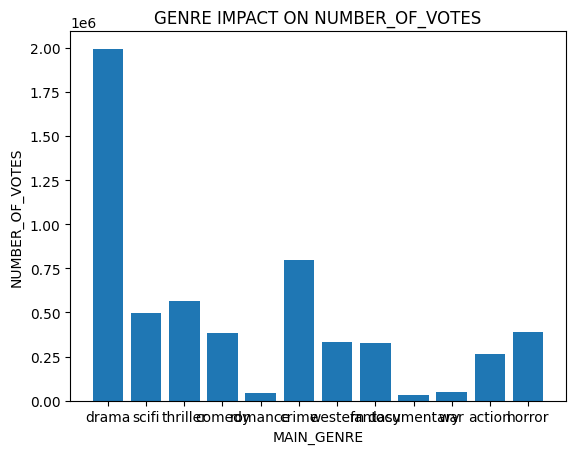

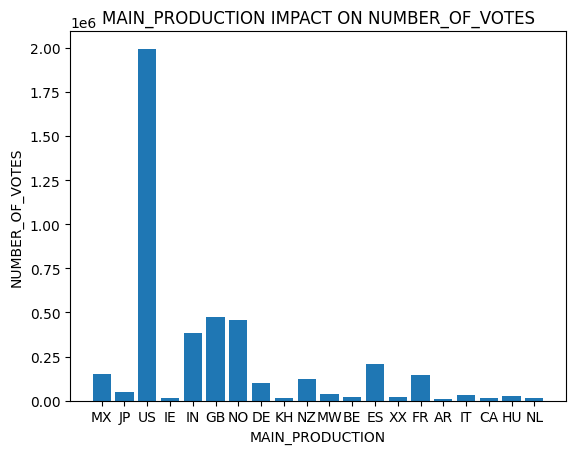

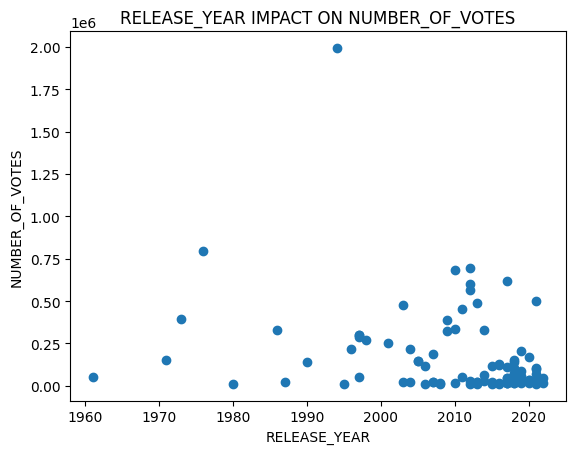

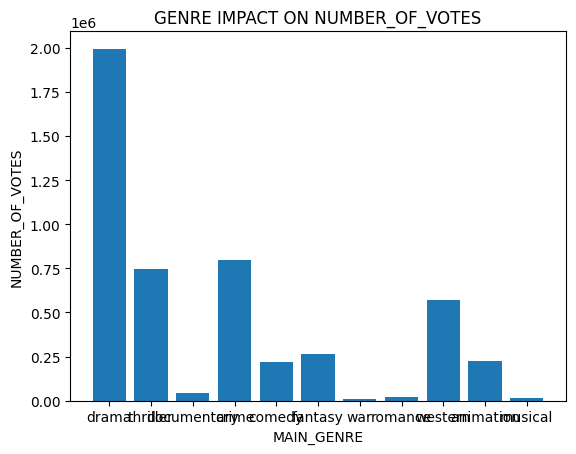

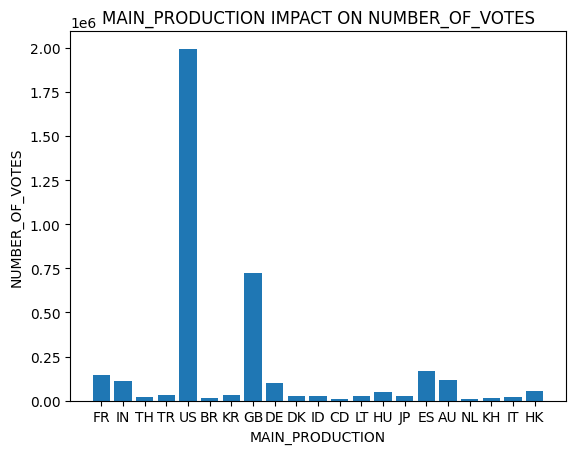

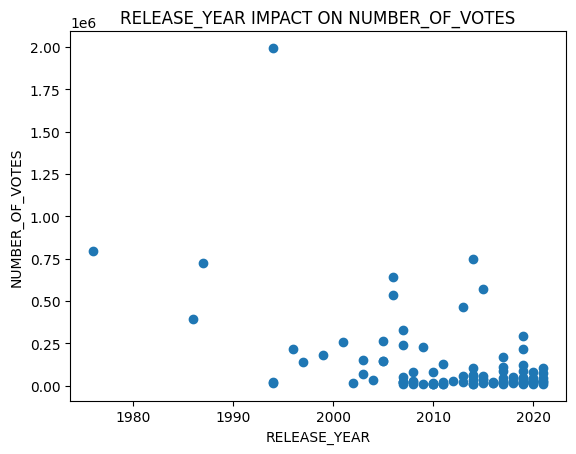

Chi-square test: chi2-statistic = 546.7707, p-value = 0.0135
Sample 1 variance: index             NaN
TITLE             NaN
RELEASE_YEAR      NaN
SCORE             NaN
NUMBER_OF_VOTES   NaN
DURATION          NaN
MAIN_GENRE        NaN
MAIN_PRODUCTION   NaN
random            NaN
dtype: float64
Sample 1 size: 0
Sample 2 variance: index             NaN
TITLE             NaN
RELEASE_YEAR      NaN
SCORE             NaN
NUMBER_OF_VOTES   NaN
DURATION          NaN
MAIN_GENRE        NaN
MAIN_PRODUCTION   NaN
random            NaN
dtype: float64
Sample 2 size: 0
One-sample t-test for column NUMBER_OF_VOTES: t-statistic = 11.4648, p-value = 0.0000
One-sample t-test for column NUMBER_OF_VOTES: t-statistic = nan, p-value = nan


C:\Users\USER\AppData\Local\Temp\ipykernel_10744\3202067101.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_movies[column] = pd.to_numeric(netflix_movies[column], errors='coerce')


('fantasy',)
Mean Squared Error: 67901646183.19
Predictions: [[1.35765487e+05 7.45375000e+00 1.21150000e+02]]
NUMBER_OF_VOTES is 135765.49
SCORE is 7.45
DURATION is 121.15


In [46]:
import numpy as np
import statistics
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import statistics
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from scipy import stats


netflix_movies = pd.read_csv(r'C://Users//USER//Downloads//Documents//Best Movies Netflix.csv')

duplicateRows = netflix_movies[netflix_movies.duplicated()]

unique_df = netflix_movies.drop_duplicates()
# Generating random numbers for each row
netflix_movies['random'] = pd.Series(np.random.rand(len(netflix_movies)))

# Sorting the DataFrame by the random numbers
netflix_movies.sort_values(by='random', inplace=True)

# we will Choose the first 100 observations as your random sample
random_sample = netflix_movies.head(100)

# we will choose the columns with integer values for the mean
selected_columns = ['RELEASE_YEAR', 'SCORE','NUMBER_OF_VOTES']

# Creating a new DataFrame with only the selected columns
selected_data = random_sample[selected_columns]

# Now i can perform operations on this DataFrame
mean_values = selected_data.mean()

a = statistics.mean(mean_values)


# Printing the mean
print("Mean is :", a)
# let's Generate new random numbers
netflix_movies['random'] = pd.Series(np.random.rand(len(netflix_movies)))

# Sorting the DataFrame again
netflix_movies.sort_values(by='random', inplace=True)

# Choosing the next 100 observations
next_random_sample = netflix_movies.head(100)


# Creating a new DataFrame with only the selected columns
next_selected_data = next_random_sample[selected_columns]

# Now i can perform operations on this DataFrame
next_mean_values = next_selected_data.mean()


b = statistics.mean(next_mean_values)

# Printing the mean
print("next Mean is :", b)

# Plotting two features
plt.bar(random_sample['MAIN_GENRE'],random_sample['NUMBER_OF_VOTES'])
plt.xlabel('MAIN_GENRE')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('GENRE IMPACT ON NUMBER_OF_VOTES')
plt.show()
# Plotting two features
plt.bar(random_sample['MAIN_PRODUCTION'],random_sample['NUMBER_OF_VOTES'])
plt.xlabel('MAIN_PRODUCTION')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('MAIN_PRODUCTION IMPACT ON NUMBER_OF_VOTES')
plt.show()
# Plotting two features
plt.scatter(random_sample['RELEASE_YEAR'],random_sample['NUMBER_OF_VOTES'])
plt.xlabel('RELEASE_YEAR')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('RELEASE_YEAR IMPACT ON NUMBER_OF_VOTES')
plt.show()
# Plotting two features
plt.bar(next_random_sample['MAIN_GENRE'],next_random_sample['NUMBER_OF_VOTES'])
plt.xlabel('MAIN_GENRE')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('GENRE IMPACT ON NUMBER_OF_VOTES')
plt.show()
# Plotting two features
plt.bar(next_random_sample['MAIN_PRODUCTION'],next_random_sample['NUMBER_OF_VOTES'])
plt.xlabel('MAIN_PRODUCTION')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('MAIN_PRODUCTION IMPACT ON NUMBER_OF_VOTES')
plt.show()
# Plotting two features
plt.scatter(next_random_sample['RELEASE_YEAR'],next_random_sample['NUMBER_OF_VOTES'])
plt.xlabel('RELEASE_YEAR')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('RELEASE_YEAR IMPACT ON NUMBER_OF_VOTES')
plt.show()

# Create a contingency table
contingency_table = pd.crosstab(netflix_movies['MAIN_PRODUCTION'], netflix_movies['MAIN_GENRE'])

# Perform the chi-square test of independence
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square test: chi2-statistic = {chi2_statistic:.4f}, p-value = {p_value:.4f}")


# Assuming 'sample1' and 'sample2' are your DataFrames

# Function to clean and convert data
def clean_data(netflix_movies):
    for column in netflix_movies.columns:
        netflix_movies[column] = pd.to_numeric(netflix_movies[column], errors='coerce')
    netflix_movies = netflix_movies.dropna()
    return netflix_movies

# Clean both samples
sample1_clean = clean_data(random_sample)
sample2_clean = clean_data(next_random_sample)

# Drop NaNs
sample1_clean = random_sample.dropna()
sample2_clean = next_random_sample.dropna()

# Check variance and sample size
print("Sample 1 variance:", sample1_clean.var())
print("Sample 1 size:", len(sample1_clean))

print("Sample 2 variance:", sample2_clean.var())
print("Sample 2 size:", len(sample2_clean))

# Specify the column to test
column_to_test = 'NUMBER_OF_VOTES'  # replace with the actual column name

# Extracting the sample and dropping NaNs
sample1_clean = netflix_movies.dropna(subset=['NUMBER_OF_VOTES'])

# Performing one-sample t-test for each column in sample1_clean
for column in ['NUMBER_OF_VOTES']:
    if len(sample1_clean['NUMBER_OF_VOTES']) > 1 and sample1_clean['NUMBER_OF_VOTES'].var() > 0:
        # Performing one-sample t-test for sample1
        t_statistic1, p_value1 = stats.ttest_1samp(sample1_clean['NUMBER_OF_VOTES'], popmean=25)
    else:
        t_statistic1, p_value1 = np.nan, np.nan
    print('One-sample t-test for column {}: t-statistic = {:.4f}, p-value = {:.4f}'.format(column, t_statistic1, p_value1))

for column in ['NUMBER_OF_VOTES']:
    if len(sample2_clean['NUMBER_OF_VOTES']) > 1 and sample2_clean['NUMBER_OF_VOTES'].var() > 0:
        # Performing one-sample t-test for sample1
        t_statistic2, p_value2 = stats.ttest_2samp(sample2_clean['NUMBER_OF_VOTES'], popmean=25)
    else:
        t_statistic2, p_value2 = np.nan, np.nan
    print('One-sample t-test for column {}: t-statistic = {:.4f}, p-value = {:.4f}'.format(column, t_statistic2, p_value2))                                                                                           

# Generate example data





# Connecting to an SQLite database (creates a new file if it doesn't exist)
conn = sqlite3.connect('mydatabase.db')

# Creating a cursor object to execute SQL commands
cursor = conn.cursor()
# Writing DataFrame to SQL table
netflix_movies.to_sql('Best_Movies_Netflix', conn, if_exists='replace', index=False)



# let's look at the most and less popular movies in the united states,britain,india and japan
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US') ; ")
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US'  AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US') ; ")
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US'); ")

cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB'  AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB') ; ")
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB' AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB'); ")
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB'); ")

cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN'); ")
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND  NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN'); ")
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND  NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN'); ")

cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP'); ")
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP'); ")
cursor.execute("SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP'); ")


# Commiting the changes
conn.commit()

# Fetching all rows
rows = cursor.fetchall()
for row in rows:
    print(row)

# Closing the connection
conn.close()
#now, we will try to predict NUMBER_OF_VOTES, SCORE and DURATION of an upcoming movie on netflix called trigger warning
# Extracting features and targets
X = random_sample[['MAIN_GENRE', 'MAIN_PRODUCTION']]
y = random_sample[['NUMBER_OF_VOTES', 'SCORE', 'DURATION']]

# Creating prediction DataFrame
X_pred = pd.DataFrame({
    'MAIN_GENRE': ['thriller'], 
    'MAIN_PRODUCTION': ['US']
})

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['MAIN_GENRE', 'MAIN_PRODUCTION'])
    ])


# Creating a pipeline with the preprocessor and the decision tree regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=5))
])

# Fitting the model to the training data
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Making predictions on the new data
predictions = model.predict(X_pred)
print(f"Predictions: {predictions}")
# Printing each feature with its predicted value
for feature, value in zip(y.columns, predictions[0]):
    print(f"{feature} is {value:.2f}")